# Running T<sub>1</sub> Experiments with Qiskit

In a T<sub>1</sub> experiment, we measure an excited qubit after a delay. Due to decoherence processes (e.g. amplitude damping channel), it is possible that, at the time of measurement, after the delay, the qubit will not be excited anymore. The larger the delay time is, the more likely is the qubit to fall to the ground state. The goal of the experiment is to characterize the decay rate of the qubit towards the ground state.

We start by fixing a delay time $t$ and a number of shots $s$. Then, by repeating $s$ times the procedure of exciting the qubit, waiting, and measuring, we estimate the probability to measure $|1\rangle$ after the delay. We repeat this process for a set of delay times, resulting in a set of probabilities estimates.

In the absence of state preparation and measurement errors, the probablity to measure |1> after time $t$ is $e^{-t/T_1}$, for a constant $T_1$ (the coherence time), which is our target number. Since state preparation and measurement errors do exist, the qubit's decay towards the ground state assumes the form $Ae^{-t/T_1} + C$, for parameters $A, T_1$, and $C$, which we deduce form the probabilities estimates. To this end, the T<sub>1</sub> experiment internally calls the `curve_fit` method of `scipy.optimize`.

The following code demonstrates a basic run of a T<sub>1</sub> experiment for qubit 0.

{'value': 2.236133108824824e-05,
 'stderr': 5.555932448663175e-06,
 'unit': 's',
 'label': 'T1',
 'fit': {'popt': array([9.01390153e-01, 2.23613311e-05, 6.79717372e-02]),
  'popt_keys': ['a', 'tau', 'c'],
  'popt_err': array([1.00125474e-01, 5.55593245e-06, 1.10110130e-01]),
  'pcov': array([[ 1.00251105e-02,  5.08704846e-07, -1.07345973e-02],
         [ 5.08704846e-07,  3.08683854e-11, -5.94715374e-07],
         [-1.07345973e-02, -5.94715374e-07,  1.21242407e-02]]),
  'reduced_chisq': 0.579249919806449,
  'dof': 10,
  'xrange': [1e-06, 3.7e-05],
  'circuit_unit': 'us'},
 'quality': 'computer_bad',
 'success': True}

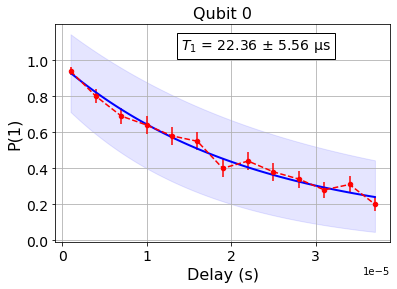

In [1]:
from qiskit_experiments.characterization import T1Experiment
from qiskit_experiments.composite import ParallelExperiment

# A T1 simulator
from qiskit_experiments.test.t1_backend import T1Backend

# Simulate T1 of 25 microseconds
t1 = 25
backend = T1Backend(t1=[t1*1e-6])

# Time intervals to wait before measurement
delays = list(range(1, 40, 3))

# Create an experiment for qubit 0,
# setting the unit to microseconds,
# with the specified time intervals
exp = T1Experiment(qubit=0, 
                   delays=delays,
                   unit="us")

# Run the experiment circuits with 10000 shots each,
# and analyze the result
exp_data = exp.run(backend=backend,
                   shots=100)

# Print the result
res = exp_data.analysis_result(0)
res

It is possible to override the default analysis options. In particular, be aware of the `t1_guess` and `t1_bounds` options. In the following snippet, we instruct to look for T<sub>1</sub> in the range between 3 to 10. Since T<sub>1</sub> is outside this range (equals 25 in the example), the analysis will fail.

In [2]:
exp.set_analysis_options(t1_bounds=[3, 10])
fail_fit = exp.run(backend=backend,
                   shots=100)

print(fail_fit.analysis_result(0))


- success: False
- error_message: 'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'


In [3]:
# Return the default analysis option
exp.set_analysis_options(t1_bounds=exp._default_analysis_options().get("t1_bounds"))

You can combine a new experiment with an old one. This way, the T<sub>1</sub> estimate will be based on the data of both experiments, hence will be more accurate. This is done by setting the `experiment_data` parameter of `run` with the returned value of an earlier call to `run`:

T1: 2.3609233198459448e-05
Error bar: 3.7609231511079294e-06
Previous error bar: 5.555932448663175e-06


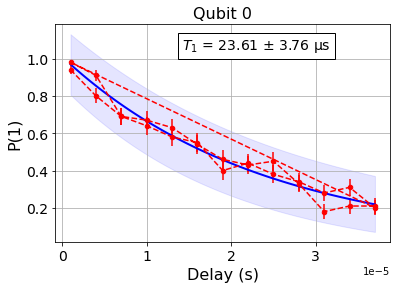

In [4]:
# Run again and combine with an earlier run.
combined = exp.run(backend=backend,
                   shots=100,
                   experiment_data=exp_data)

# `combined` consists now of two analysis results:
# - The result from the first execution of the experiment
# - The result of the two first executions together
combined_analysis_result = combined.analysis_result(1)
print("T1:", combined_analysis_result["value"])
print("Error bar:", combined_analysis_result["stderr"])

# Compare with the previous error bar:
print("Previous error bar:", res["stderr"])

To measure T1 of multiple qubits in the same experiment, we create a parallel experiment:

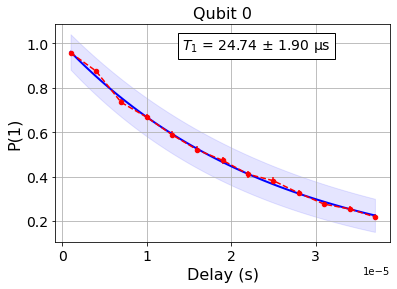

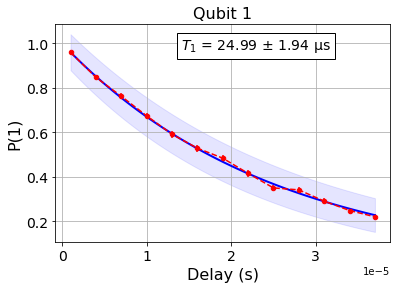

In [6]:
# A simulator where qubits 0 and 1 have T1 of 25 microseconds
backend = T1Backend(t1=[t1*1e-6, t1*1e-6])

# An experiment for qubit 1
exp_q1 = T1Experiment(qubit=1, 
                      delays=delays,
                      unit="us")

# A parallel experiment
parallel_exp = ParallelExperiment([exp, exp_q1])
parallel_data = parallel_exp.run(backend=backend)